In [1]:
import sklearn
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
print(mnist.keys())

dict_keys(['DESCR', 'COL_NAMES', 'target', 'data'])


In [4]:
X,y = mnist["data"],mnist["target"]

In [5]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [42]:
idx = 36000
some_digit = X[idx]
some_digit_image = some_digit.reshape(28,28)

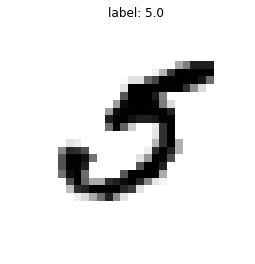

In [43]:
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.title("label: %s" %y[idx])
plt.show()

In [34]:
X_train,X_test,y_train,y_test = X[:60000], X[60000:],y[:60000],y[60000:]

In [35]:
import numpy as np

#### Garantindo que os dados no treinamento, sejam todos aleatorios, impedindo que algum numero fique de fora em um batch

In [36]:
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]

#### Treinando um classificador binario - Simplificando para treinar apenas o numero 5

In [37]:
y_train_5 = (y_train ==5)
y_test_5 = (y_test ==5)

In [38]:
from sklearn.linear_model import SGDClassifier

In [39]:
# utiliza-se 'random_state', para conseguir resultados reproduziveis, no mais, ele é estocastico
sgd_clf = SGDClassifier (random_state = 42)
sgd_clf.fit(X_train, y_train_5)

C:\Users\Tales\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

#### Verificando se o algoritmo reconheceu o numero 5 (some_digit)

In [45]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

### MEDIDAS DE DESEMPENHO

In [48]:
# problema com 'StratifiedKfold', para resolver tem que instalar sklearn novamente com pip install
from sklearn.model_selection import StratifiedKfold
from sklearn.base import clone

#### Confusion Matrix

In [49]:
from sklearn.model_selection import cross_val_predict

In [50]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [51]:
from sklearn.metrics import confusion_matrix

In [52]:
# ordenação da confusion matrix, cada linha representa classe atual, cada coluna representa classe prevista
# first row - considera non-5 images (negative class): 52453 verdadeiros negativos, 2126 falso negativos
# second row - considera 5 images (true class): 1462 falso negativos, 2959 corretos (true positives)
confusion_matrix(y_train_5,y_train_pred)

array([[52453,  2126],
       [ 1462,  3959]], dtype=int64)